<a href="https://colab.research.google.com/github/ivanadj3/MIEP/blob/main/MIEP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model za klasifikaciju gustine dojki**



Mašinsko učenje (ML) može biti efikasno korišćeno za analizu i klasifikaciju skupova podataka o raku dojke, pružajući dragocene uvide i pomažući u ranom otkrivanju i planiranju lečenja.

Skupovi podataka o raku dojke obično sadrže karakteristike koje opisuju osobine ćelijskih jezgara prisutnih u biopsijama raka dojke. U ovom projektu radili smo sa dijagnostičkim skupom podataka pod nazivom MIAS Mammography Dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
img_height, img_width = 224, 224
batch_size = 16
num_classes = 4

In [ ]:
dataset_dir = '/content/drive/MyDrive/MIEP/all-mias'
output_dir = '/content/drive/MyDrive/MIEP/all-mias_processed'

In [ ]:
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Kreiranje poddirektorijuma za svaku klasu

classes = ['A', 'B', 'C', 'D']
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

# Listanje i etiketiranje fajlova

file_paths = []
file_labels = []

for filename in os.listdir(dataset_dir):
    if filename.endswith('.pgm') and filename.startswith('mdb'):
        file_number = int(filename[3:6])

        if file_number % 4 == 0:
            class_label = 'A'
        elif file_number % 4 == 1:
            class_label = 'B'
        elif file_number % 4 == 2:
            class_label = 'C'
        else:
            class_label = 'D'

        file_paths.append(os.path.join(dataset_dir, filename))
        file_labels.append(class_label)

In [ ]:
import shutil

Podela podataka na trening i test skup:

In [ ]:
train_files, test_files, train_labels, test_labels = train_test_split(file_paths, file_labels, test_size=0.2, stratify=file_labels, random_state=42)

# Kopiranje fajlova u odgovarajuće foldere

for file, label in zip(train_files, train_labels):
    dst = os.path.join(train_dir, label, os.path.basename(file))
    shutil.copyfile(file, dst)

for file, label in zip(test_files, test_labels):
    dst = os.path.join(test_dir, label, os.path.basename(file))
    shutil.copyfile(file, dst)

print("Slike su uspešno podeljene i kopirane u odgovarajuće direktorijume.")

Slike su uspešno podeljene i kopirane u odgovarajuće direktorijume.


In [ ]:
def pgm_to_rgb(pgm_image_path):
    pgm_image = cv2.imread(pgm_image_path, cv2.IMREAD_GRAYSCALE)
    rgb_image = cv2.cvtColor(pgm_image, cv2.COLOR_GRAY2RGB)
    return rgb_image

In [ ]:
def convert_and_save_images(files, labels, output_directory):
    for file, label in zip(files, labels):
        dst = os.path.join(output_directory, label, os.path.basename(file).replace('.pgm', '.jpg'))
        rgb_image = pgm_to_rgb(file)
        cv2.imwrite(dst, rgb_image)

convert_and_save_images(train_files, train_labels, train_dir)
convert_and_save_images(test_files, test_labels, test_dir)

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report

img_height, img_width = 224, 224
batch_size = 16
num_classes = 4

dataset_dir = '/content/drive/MyDrive/MIEP/all-mias'
output_dir = '/content/drive/MyDrive/MIEP/all-mias_processed'

train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

classes = ['A', 'B', 'C', 'D']

def pgm_to_rgb(pgm_image_path):
    pgm_image = cv2.imread(pgm_image_path, cv2.IMREAD_GRAYSCALE)
    rgb_image = cv2.cvtColor(pgm_image, cv2.COLOR_GRAY2RGB)
    return rgb_image

file_paths = []
file_labels = []

for filename in os.listdir(dataset_dir):
    if filename.endswith('.pgm') and filename.startswith('mdb'):
        file_number = int(filename[3:6])
        class_label = classes[file_number % 4]

        file_paths.append(os.path.join(dataset_dir, filename))
        file_labels.append(class_label)

train_files, test_files, train_labels, test_labels = train_test_split(file_paths, file_labels, test_size=0.2, stratify=file_labels, random_state=42)

# Konvertovanje i čuvanje slika

def convert_and_save_images(files, labels, output_directory):
    for file, label in zip(files, labels):
        dst = os.path.join(output_directory, label, os.path.basename(file).replace('.pgm', '.jpg'))
        rgb_image = pgm_to_rgb(file)
        cv2.imwrite(dst, rgb_image)

# Pozivanje funkcije za konvertovanje za trening i test skupove

convert_and_save_images(train_files, train_labels, train_dir)
convert_and_save_images(test_files, test_labels, test_dir)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Učitavanje i priprema podataka za model

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

# Kreiranje CNN modela

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Callback-ovi za rano zaustavljanje i čuvanje modela

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/drive/My Drive/breast_density_model.keras', save_best_only=True)
]

Found 257 images belonging to 4 classes.
Found 65 images belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
print(f'Broj uzoraka za trening: {train_generator.samples}')
print(f'Broj uzoraka za validaciju: {validation_generator.samples}')


Broj uzoraka za trening: 257
Broj uzoraka za validaciju: 65


In [ ]:
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.2513 - loss: 1.3934 - val_accuracy: 0.1250 - val_loss: 1.4151
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3750 - loss: 1.3619 - val_accuracy: 0.0000e+00 - val_loss: 1.4726
Epoch 3/15


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


16/16 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.2468 - loss: 1.3926 - val_accuracy: 0.2344 - val_loss: 1.4007
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3125 - loss: 1.3649 - val_accuracy: 0.0000e+00 - val_loss: 1.4844
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.2450 - loss: 1.3750 - val_accuracy: 0.2500 - val_loss: 1.3974
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.1250 - loss: 1.4674 - val_accuracy: 0.0000e+00 - val_loss: 1.3652
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.2686 - loss: 1.3826 - val_accuracy: 0.1562 - val_loss: 1.3806
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.3125 - loss: 1.3694 - val_accuracy: 1.0000 - val_loss: 1.3031
Epoch 9/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.3007 - loss: 1.3812 - val_accuracy: 0.2031 - val_loss: 1.3923
Epoch 10/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1875 - loss: 1.4048 - val_accuracy: 0.0000e+00 - val

Found 65 images belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 987ms/step
Matrica konfuzije:
[[ 2 12  0  2]
 [ 5  5  1  5]
 [ 2 14  0  1]
 [ 4  6  1  5]]


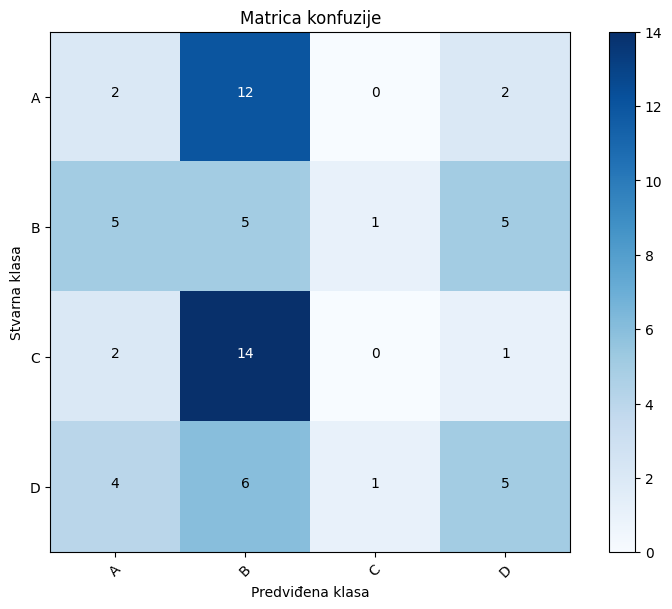

              precision    recall  f1-score   support

           A       0.15      0.12      0.14        16
           B       0.14      0.31      0.19        16
           C       0.00      0.00      0.00        17
           D       0.38      0.31      0.34        16

    accuracy                           0.18        65
   macro avg       0.17      0.19      0.17        65
weighted avg       0.17      0.18      0.17        65



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# Kreiranje generatora za test set

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# Predviđanje na test skupu

test_steps = len(test_generator)
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Izračunavanje matrice konfuzije

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print('Matrica konfuzije:')
print(conf_matrix)

# Vizualizacija matrice konfuzije

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('Matrica konfuzije')
plt.colorbar()

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Stvarna klasa')
plt.xlabel('Predviđena klasa')
plt.show()

print(classification_report(true_classes, predicted_classes, target_names=class_labels))

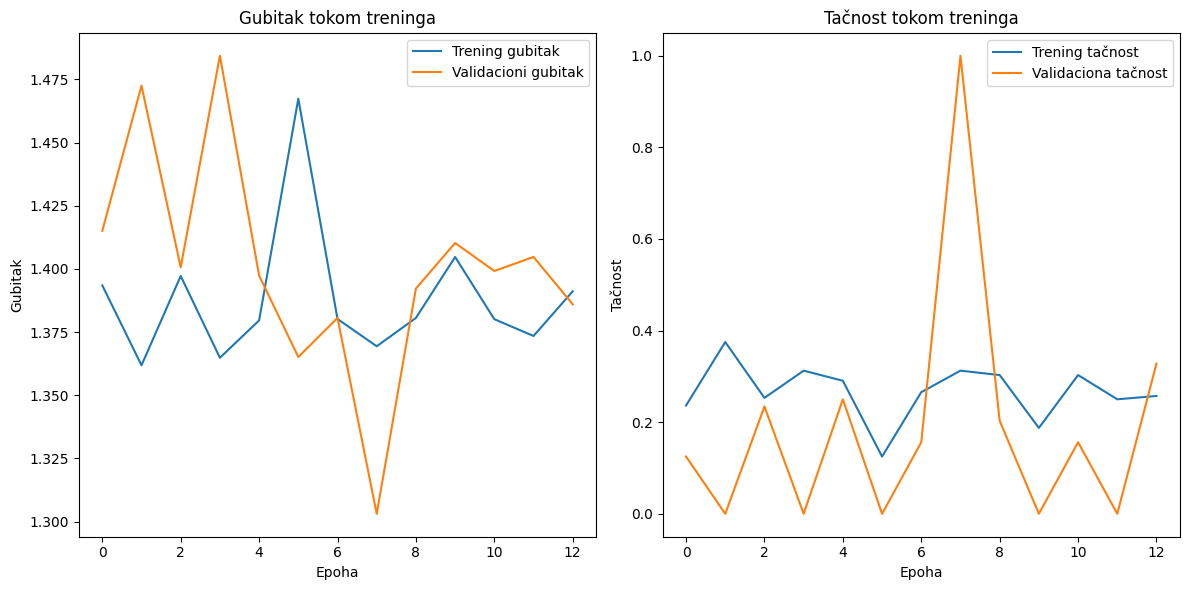

In [ ]:
# Funkcija za prikaz istorije treniranja

def plot_training(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Trening gubitak')
    plt.plot(history.history['val_loss'], label='Validacioni gubitak')
    plt.xlabel('Epoha')
    plt.ylabel('Gubitak')
    plt.title('Gubitak tokom treninga')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Trening tačnost')
    plt.plot(history.history['val_accuracy'], label='Validaciona tačnost')
    plt.xlabel('Epoha')
    plt.ylabel('Tačnost')
    plt.title('Tačnost tokom treninga')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training(history)